In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
%matplotlib inline

In [2]:
def new_radec_format(ra_long, dec_long):
    ra_sec = np.abs(ra_long) - 100*int(np.abs(ra_long)/100)
    ra_min = (np.abs(ra_long) - 10000*int(np.abs(ra_long)/10000) - ra_sec)/100
    ra_hour = (np.abs(ra_long) - ra_min*100 - ra_sec)/10000
    ra_degree =    (ra_hour + ra_min/60.0 + ra_sec/3600.0) * (360.0/24.0)

    dec_arcsec = np.abs(dec_long) - 100*int(np.abs(dec_long)/100)
    dec_arcmin = (np.abs(dec_long) - 10000*int(np.abs(dec_long)/10000) - dec_arcsec)/100
    dec_deg = (np.abs(dec_long) - dec_arcmin*100 - dec_arcsec)/10000
    if(dec_long<0):
        sign = -1.0
    else:
        sign = +1.0
    dec_degree = sign*dec_deg + sign*dec_arcmin/60.0 + sign*dec_arcsec/3600.0
    return ra_degree, dec_degree

In [3]:
data = pd.read_csv("../data/obs/cosmicflows_2MPP.csv")

In [4]:
data[0:10]

,"#""The Catalogue of Principal Galaxies (PGC) Number""","Apparent Ks 20 mag/as^2 isophote magnitude adjusted for cosmological surface brightness dimming, extinction, filter redshift response, and stellar evolution, as defined by Lavaux and Hudson",VelocityCMB,LuminosityDistance,Number of distance sources,Right Ascension (J2000),Declination (J2000)
0,2,9.65,4739.0,NaN,NaN,NaN,NaN
1,4,NaN,NaN,50.58,1.0,3.5,230515.0
2,5,10.69,10044.0,NaN,NaN,NaN,NaN
3,12,11.75,6178.0,NaN,NaN,NaN,NaN
4,14,10.84,11431.0,NaN,NaN,NaN,NaN
5,15,12.31,11013.0,NaN,NaN,NaN,NaN
6,16,11.76,5359.0,NaN,NaN,NaN,NaN
7,18,10.89,5087.0,NaN,NaN,NaN,NaN
8,23,11.25,11007.0,NaN,NaN,NaN,NaN
9,27,12.15,10921.0,150.66,1.0,23.5,-65610.0


In [5]:
n = len(data)
ra = np.ones(n)
dec = np.ones(n)
for i in range(n):
    ra_original = data['Right Ascension (J2000)'][i]
    dec_original = data['Declination (J2000)'][i]
    if(np.isnan(ra_original)|np.isnan(dec_original)):
        ra[i] = ra_original
        dec[i] = dec_original
    else:
        ra[i], dec[i] = new_radec_format(ra_original, dec_original)

In [6]:
ra_series = pd.Series(data=ra, name='RA', index=data.index, dtype='float')
dec_series = pd.Series(data=dec, name='DEC', index=data.index, dtype='float')

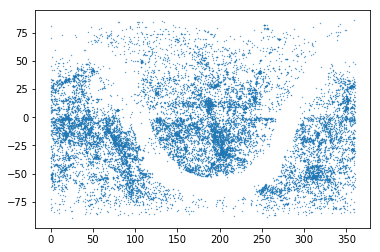

In [7]:
plt.scatter(ra, dec, s=0.1)

In [8]:
data = data.assign(RA=ra_series.values)
data = data.assign(DEC=dec_series.values)
data[0:10]

,"#""The Catalogue of Principal Galaxies (PGC) Number""","Apparent Ks 20 mag/as^2 isophote magnitude adjusted for cosmological surface brightness dimming, extinction, filter redshift response, and stellar evolution, as defined by Lavaux and Hudson",VelocityCMB,LuminosityDistance,Number of distance sources,Right Ascension (J2000),Declination (J2000),RA,DEC
0,2,9.65,4739.0,NaN,NaN,NaN,NaN,NaN,NaN
1,4,NaN,NaN,50.58,1.0,3.5,230515.0,0.014583,23.087500
2,5,10.69,10044.0,NaN,NaN,NaN,NaN,NaN,NaN
3,12,11.75,6178.0,NaN,NaN,NaN,NaN,NaN,NaN
4,14,10.84,11431.0,NaN,NaN,NaN,NaN,NaN,NaN
5,15,12.31,11013.0,NaN,NaN,NaN,NaN,NaN,NaN
6,16,11.76,5359.0,NaN,NaN,NaN,NaN,NaN,NaN
7,18,10.89,5087.0,NaN,NaN,NaN,NaN,NaN,NaN
8,23,11.25,11007.0,NaN,NaN,NaN,NaN,NaN,NaN
9,27,12.15,10921.0,150.66,1.0,23.5,-65610.0,0.097917,-6.936111


2755
1325


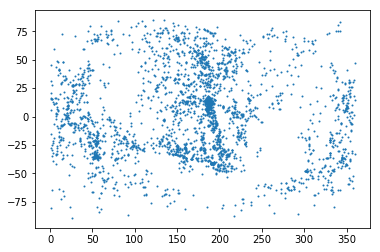

In [9]:
max_distance = 45.0
plt.scatter(data['RA'][data['LuminosityDistance']<max_distance],data['DEC'][data['LuminosityDistance']<max_distance], s =1.0)
print(len(data['RA'][data['LuminosityDistance']<max_distance]))
print(np.count_nonzero(np.isnan(data['VelocityCMB'][data['LuminosityDistance']<max_distance])))

1426


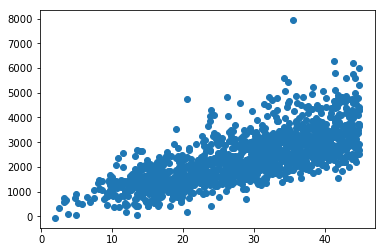

In [10]:
ii = (data['LuminosityDistance']<max_distance) & (~np.isnan(data['VelocityCMB'])) 
ii = ii & (~np.isnan(data['LuminosityDistance'])) & (data['VelocityCMB']<10000)
plt.scatter(data['LuminosityDistance'][ii], data['VelocityCMB'][ii])
filtered_data = data[ii]
print(len(filtered_data))

In [11]:
n_points = len(filtered_data)
cartesian_data = np.ones((n_points,3))
theta = np.deg2rad(filtered_data['DEC'] - 90.0)
phi = np.deg2rad(filtered_data['RA'])
cartesian_data[:,0] = filtered_data['LuminosityDistance'].values * np.sin(theta) * np.cos(phi)
cartesian_data[:,1] = filtered_data['LuminosityDistance'].values * np.sin(theta) * np.sin(phi)
cartesian_data[:,2] = filtered_data['LuminosityDistance'].values * np.cos(theta)
vradial_data = filtered_data['VelocityCMB'].values
dradial_data = filtered_data['LuminosityDistance'].values

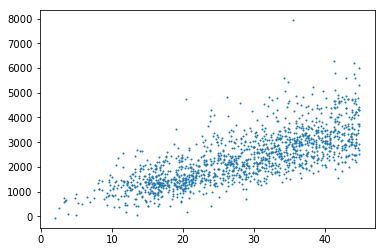

In [12]:
plt.scatter(dradial_data, vradial_data, s=1.0)

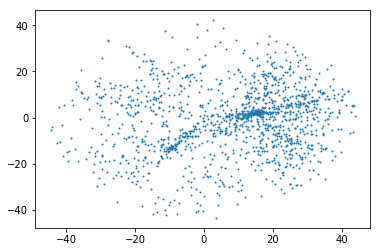

In [13]:
plt.scatter(cartesian_data[:,0], cartesian_data[:,1], s=1.0)

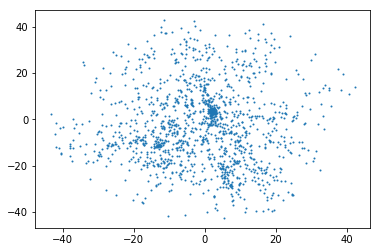

In [14]:
plt.scatter(cartesian_data[:,1], cartesian_data[:,2], s=1.0)

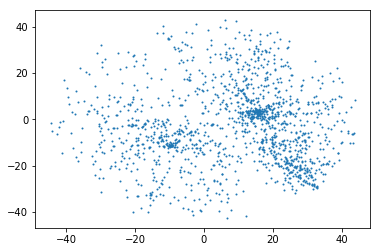

In [15]:
plt.scatter(cartesian_data[:,0], cartesian_data[:,2], s=1.0)

In [16]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(cartesian_data)
dist, ind = nbrs.kneighbors(cartesian_data)
print(dist.shape)
neighbor_index = ind[:,1]
neighbor_list = ind[:,2:]
print(np.shape(neighbor_list))

#define pairs
n_pairs = 0
halo_A_id = np.empty((0), dtype=int)
halo_B_id = np.empty((0), dtype=int)
n = len(cartesian_data)
print(n)
for i in range(n):
    j = neighbor_index[i] % n # nearest neighbor of i
    l = neighbor_index[neighbor_index[i]]% n # nearest neighbor of j
    other_j = neighbor_list[i,:] % n # all neightbors of i.
    other_l = neighbor_list[neighbor_index[i],:] % n # all neightbors of i-th's neighbors
    if(i==l):# reciprocity principle
        if((not (j in halo_A_id)) & (not (i in halo_B_id))): # don't add pairs that are already in the list
            dist_limit = 2.5
            massive_close_to_i = any((dist[i,2:]<dist_limit))
            massive_close_to_j = any((dist[j,2:]<dist_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)): 
                n_pairs = n_pairs + 1
                halo_A_id = np.append(halo_A_id, int(i))
                halo_B_id = np.append(halo_B_id, int(j))
print(n_pairs)

(1426, 20)
(1426, 18)
1426
225


In [17]:
pair_3d = np.sqrt((cartesian_data[halo_B_id, 0] - cartesian_data[halo_A_id,0])**2
                 +(cartesian_data[halo_B_id, 1] - cartesian_data[halo_A_id,1])**2
                 +(cartesian_data[halo_B_id, 2] - cartesian_data[halo_A_id,2])**2)
pair_d = (cartesian_data[halo_B_id, 2] - cartesian_data[halo_A_id,2])
hubble = 78.0
pair_v = (vradial_data[halo_B_id] - dradial_data[halo_B_id]*hubble) - (vradial_data[halo_A_id] -dradial_data[halo_A_id]*hubble)

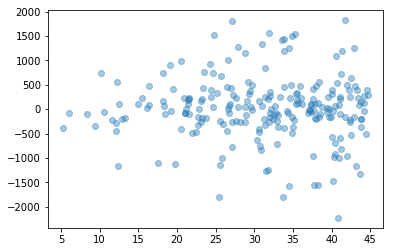

In [18]:
plt.scatter(0.5*(dradial_data[halo_B_id]+dradial_data[halo_A_id]), pair_v, alpha=0.4)

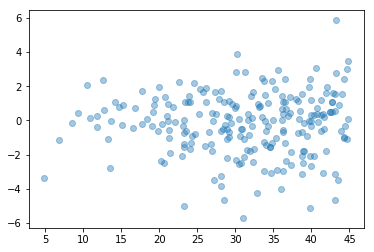

In [19]:
plt.scatter(dradial_data[halo_B_id], pair_d, alpha=0.4)

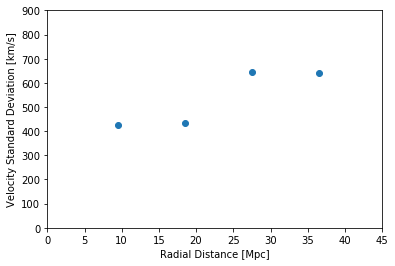

In [29]:
d_bins = np.arange(5,50,9)
d_center = 0.5*(d_bins[0:-1] + d_bins[1:])
n_bins = len(d_center)
n_inside = np.zeros(n_bins)
sigma_d = np.zeros(n_bins)
sigma_0 = np.zeros(n_bins)
sigma_v = np.zeros(n_bins)
for i in range(n_bins):
    mid = 0.5*(dradial_data[halo_B_id]+dradial_data[halo_A_id])
    ii = (mid>d_bins[i]) & (mid<d_bins[i+1])
    if(np.count_nonzero(ii)):
        n_in = np.count_nonzero(ii) 
        sigma_d[i] = pair_d[ii].std()
        sigma_v[i] = pair_v[ii].std()
        sigma_0[i] = np.sqrt(sigma_v[i]**2 - (d_center[i]*78*0.10)**2)
        n_inside[i] = np.count_nonzero(ii)
#plt.plot(d_center, sigma_d)
plt.scatter((d_center), sigma_0)
plt.xlim([0,45])
plt.ylim([0,900])
plt.xlabel('Radial Distance [Mpc]')
plt.ylabel('Velocity Standard Deviation [km/s]')

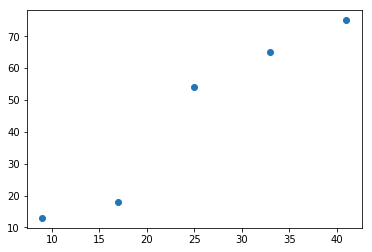

In [28]:
plt.scatter(d_center, n_inside)

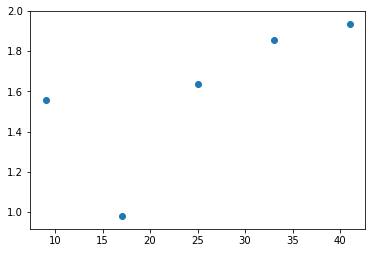

In [22]:
plt.scatter(d_center, sigma_d)

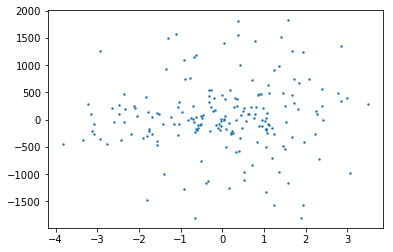

In [31]:
plt.scatter(pair_d[pair_3d<4.0], pair_v[pair_3d<4.0],s=2.0)
#plt.ylim([-2000,2000])

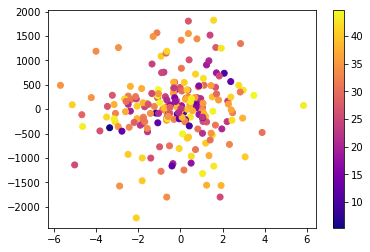

In [57]:
plt.scatter(pair_d, pair_v, c=mid, cmap='plasma')
plt.colorbar()

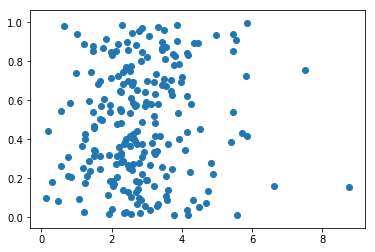

In [24]:
cos_theta = np.abs(pair_d)/pair_3d
plt.scatter(pair_3d, cos_theta)

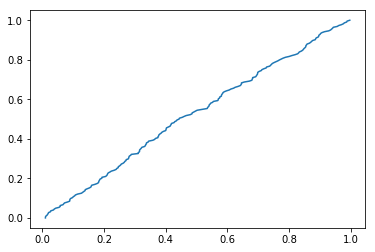

In [25]:
cumulative = np.linspace(0.0,1.0, len(cos_theta))
cos_theta_cum = np.sort(cos_theta)

plt.plot(cos_theta_cum, cumulative)

median delta_d_radial -0.032578653464661045 sigma 1.2325835263524643


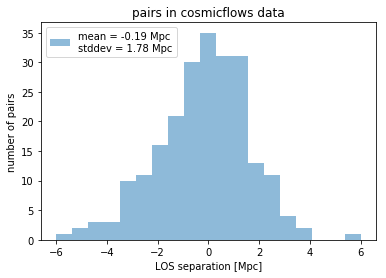

In [26]:
p = np.percentile(pair_d, q=[34,50,66])
print('median delta_d_radial {} sigma {}'.format(p[1], p[2]-p[0]))
a = plt.hist((pair_d), bins=np.linspace(-6,6,20), alpha=0.5, label='mean = {:.2f} Mpc \nstddev = {:.2f} Mpc'.format(pair_d.mean(), pair_d.std()))
plt.xlabel('LOS separation [Mpc]')
plt.ylabel('number of pairs')
plt.title('pairs in cosmicflows data')
plt.legend()

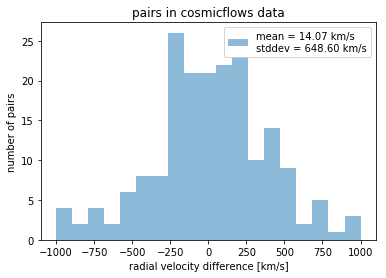

In [27]:
x = pair_v
p = np.percentile(x, q=[34,50,66])
a = plt.hist(x, bins=np.linspace(-1000,1000,20), alpha=0.5, 
             label='mean = {:.2f} km/s \nstddev = {:.2f} km/s'.format(x.mean(), x.std()))
plt.xlabel('radial velocity difference [km/s]')
plt.ylabel('number of pairs')
plt.title('pairs in cosmicflows data')
plt.legend()